In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
#Đọc dữ liệu lên
df = pd.read_csv('player.csv', sep = '\t')
df.head()

,name,pos,age,team,game,gs,mp,fg,fga,fgp,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,salary
0,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2,100.000
1,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9,25842.697
2,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9,3454.080
3,LaMarcus Aldridge,C,33,SAS,81,81,33.2,8.4,16.3,0.519,...,3.1,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3,26000.000
4,Grayson Allen,SG,23,UTA,38,2,10.9,1.8,4.7,0.376,...,0.1,0.5,0.6,0.7,0.2,0.2,0.9,1.2,5.6,2429.400


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 30 columns):
name      433 non-null object
pos       433 non-null object
age       433 non-null int64
team      433 non-null object
game      433 non-null int64
gs        433 non-null int64
mp        433 non-null float64
fg        433 non-null float64
fga       433 non-null float64
fgp       433 non-null float64
3p        433 non-null float64
3pa       433 non-null float64
3pp       433 non-null float64
2p        433 non-null float64
2pa       433 non-null float64
2pp       433 non-null float64
efgp      433 non-null float64
ft        433 non-null float64
fta       433 non-null float64
ftp       433 non-null float64
orb       433 non-null float64
drb       433 non-null float64
trb       433 non-null float64
ast       433 non-null float64
stl       433 non-null float64
blk       433 non-null float64
tov       433 non-null float64
pf        433 non-null float64
pts       433 non-null float64
salar

### Tách tập huấn luyện, tập kiểm tra

In [4]:
X = df.drop('salary', axis=1)
y = df['salary']

In [5]:
# Tách tập train và tập test theo tỉ lệ 8-2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

## Tiền xử lý tập huấn luyện

Quan sát cột lương và tuổi của tập huấn luyện

In [6]:
df_concat = pd.concat([X_train, y_train], axis=1)
df_concat.head()

,name,pos,age,team,game,gs,mp,fg,fga,fgp,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,salary
345,Glenn Robinson,SF,25,DET,47,18,13.0,1.6,3.7,0.420,...,0.4,1.1,1.5,0.4,0.3,0.2,0.4,1.0,4.2,1882.867
55,Bruce Brown,SG,22,DET,74,56,19.6,1.7,4.2,0.398,...,0.6,1.9,2.5,1.2,0.5,0.5,0.6,2.4,4.3,1416.852
408,Brad Wanamaker,PG,29,BOS,36,0,9.5,1.4,2.9,0.476,...,0.1,1.1,1.1,1.6,0.3,0.1,0.5,0.9,3.9,1445.697
323,Chandler Parsons,SF,30,MEM,25,3,19.8,2.7,7.3,0.374,...,0.2,2.6,2.8,1.7,0.8,0.2,1.3,1.8,7.5,25102.512
41,Eric Bledsoe,PG,29,MIL,78,78,29.1,6.0,12.4,0.484,...,1.1,3.6,4.6,5.5,1.5,0.4,2.1,2.0,15.9,15625.000


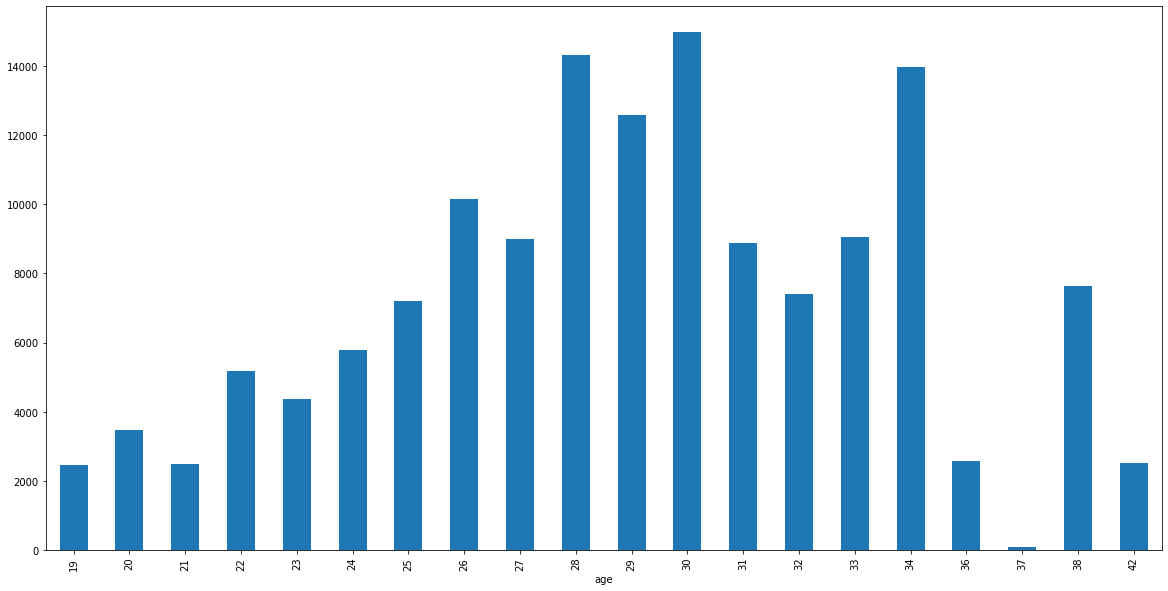

In [7]:
df_concat.groupby('age').mean()['salary'].plot.bar(x='age', y='salary', figsize=(20,10))

Từ đồ thị trên ta thấy được `salary` của tuyển thủ phân hóa theo `age` nên ta sẽ chia `age` thành 3 loại chính <br/>(vì nếu tiếp tục để ở dạng `float64` thì rất khó để mô hình đặt trọng số):
- Young (mặc định <25)
- Prime (mặc định >=25 and <=30)
- Old   (mặc định >30)

In [8]:
df.groupby('pos').count()

,name,age,team,game,gs,mp,fg,fga,fgp,3p,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,salary
pos,,,,,,,,,,,,,,,,,,,,,
C,79,79,79,79,79,79,79,79,79,79,...,79,79,79,79,79,79,79,79,79,79
C-PF,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
PF,87,87,87,87,87,87,87,87,87,87,...,87,87,87,87,87,87,87,87,87,87
PF-SF,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
PG,87,87,87,87,87,87,87,87,87,87,...,87,87,87,87,87,87,87,87,87,87
SF,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
SF-SG,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
SG,105,105,105,105,105,105,105,105,105,105,...,105,105,105,105,105,105,105,105,105,105
SG-PF,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Có 1 số `pos` chỉ xuất hiện 1 đến 2 lần, nếu one-hot có thể dễ dẫn đến overfit nên những tuyển thủ chơi ở nhiều vị trí sẽ được chuyển thành vị trí đầu tiên.

Sau khi xem xét ý nghĩa của từng cột thì ta thấy được sự liên quan giữa các cột như: (`fg`, `fga`, `fgp`), (`3p`, `3pa`, `3pp`), (`2p`, `2pa`, `2pp`), (`ft`, `fta`, `ftp`).<br/>Những cột này có ý nghĩa gần giống nhau đó là `trung bình số bàn ghi được`, `trung bình số lần thử` (attempt) và `tỷ lệ thành công`.
<br/>Do đó ta sẽ quan sát hệ số tương quan của từng cột với cột `salary`.

In [9]:
df.corr()['salary']

age       0.300658
game      0.347630
gs        0.548352
mp        0.584638
fg        0.666768
fga       0.653900
fgp       0.161669
3p        0.398066
3pa       0.397588
3pp       0.102803
2p        0.619495
2pa       0.631912
2pp       0.116754
efgp      0.152363
ft        0.583913
fta       0.577454
ftp       0.214515
orb       0.320452
drb       0.535541
trb       0.500450
ast       0.500848
stl       0.475304
blk       0.317628
tov       0.557271
pf        0.347711
pts       0.663251
salary    1.000000
Name: salary, dtype: float64

Dựa theo bảng trên, nhóm quyết bỏ đi các cột có liên quan đến `tỷ lệ`.

Và việc cuối cùng phải làm là bỏ đi cột `name`

In [10]:
#Hàm dùng để chuyển 2 vị trí thành 1
def mainPos(text):
    if '-' in text:
        return text.split('-')[0]
    return text

In [11]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, young = 25, old = 30):
        self.young = young
        self.old = old
        
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        df = X_df.copy()
        df['pos'] = df['pos'].apply(mainPos)
        df.loc[X_df['age'] < self.young, 'age'] = 'young'
        df.loc[X_df['age'] > self.old, 'age'] = 'old'
        df.loc[(X_df['age'] >= self.young) & (X_df['age'] <= self.old), 'age'] = 'prime'
        df.drop(columns=['name', 'fgp', '3pp', '2pp', 'ftp', 'efgp'], inplace=True)
        return df

In [12]:
#Test
col_adderdropper = ColAdderDropper()
test_df = col_adderdropper.transform(X_train)
test_df.head()

,pos,age,team,game,gs,mp,fg,fga,3p,3pa,...,fta,orb,drb,trb,ast,stl,blk,tov,pf,pts
345,SF,prime,DET,47,18,13.0,1.6,3.7,0.4,1.3,...,0.9,0.4,1.1,1.5,0.4,0.3,0.2,0.4,1.0,4.2
55,SG,young,DET,74,56,19.6,1.7,4.2,0.3,1.3,...,0.8,0.6,1.9,2.5,1.2,0.5,0.5,0.6,2.4,4.3
408,PG,prime,BOS,36,0,9.5,1.4,2.9,0.4,1.1,...,0.8,0.1,1.1,1.1,1.6,0.3,0.1,0.5,0.9,3.9
323,SF,prime,MEM,25,3,19.8,2.7,7.3,1.2,3.8,...,1.0,0.2,2.6,2.8,1.7,0.8,0.2,1.3,1.8,7.5
41,PG,prime,MIL,78,78,29.1,6.0,12.4,1.6,4.8,...,3.0,1.1,3.6,4.6,5.5,1.5,0.4,2.1,2.0,15.9


## Tạo Pipeline tiền xử lý giá trị số và giá trị category

In [13]:
nume_cols = ['game', 'gs', 'mp', 'fg', 'fga', '3p', '3pa', '2p','2pa', 'ft', 'fta', 
             'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
cate_cols = ['pos', 'age', 'team']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nume_cols),
        ('cat', categorical_transformer, cate_cols)])

preprocess_pipeline = Pipeline(steps=[
    ('coladderdropper', ColAdderDropper()),
    ('preprocess', preprocessor),
    ('scaler', StandardScaler())])

In [14]:
#Test
X_train_pre = preprocess_pipeline.fit_transform(X_train)
X_train_pre[0]

array([-0.33909368, -0.3706334 , -0.97102169, -0.89480951, -0.89067077,
       -0.69495914, -0.68509438, -0.75385838, -0.7702865 , -0.61467823,
       -0.66441464, -0.63719733, -1.0307069 , -0.97306428, -0.93697934,
       -0.94846932, -0.57810677, -0.97283712, -1.1430745 , -0.88710227,
       -0.47182077, -0.51261459, -0.51261459,  2.37778177, -0.57957513,
       -0.37169597,  1.14309521, -0.89559105, -0.18954721, -0.18120657,
       -0.20535013, -0.16342041, -0.18954721, -0.20535013, -0.18954721,
       -0.19758299,  5.06116435, -0.17251639, -0.19758299, -0.16342041,
       -0.18120657, -0.18120657, -0.18954721, -0.18954721, -0.18954721,
       -0.18120657, -0.19758299, -0.18120657, -0.18120657, -0.15384615,
       -0.20535013, -0.18954721, -0.19758299, -0.18120657, -0.16342041,
       -0.18120657, -0.17251639, -0.18954721])

## Lần lượt thử các thuật toán trong Scikit 

### Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
linear_pipeline = Pipeline(steps=[
    ('pre_pipeline', preprocess_pipeline),
    ('linear_regression', LinearRegression())])

In [16]:
linear_pipeline.fit(X_train, y_train)
y_pred = linear_pipeline.predict(X_test)
linear_pipeline.score(X_train, y_train)

0.6201694764159636

In [17]:
linear_pipeline.score(X_test, y_test)

0.3791292710597256

#### r2_score khá thấp nên ta xem thử kết quả dự đoán ra là gì

In [18]:
y_pred[y_pred < 0]

array([-1365.69999215, -4383.69999215, -2790.69999215, -4497.69999215,
       -2535.69999215,  -741.69999215, -2443.69999215, -1063.69999215,
       -1327.69999215,  -217.69999215, -1797.69999215, -1267.69999215,
       -1767.69999215, -1825.69999215, -6861.69999215])

#### Có 1 số tuyển thủ bị dự đoán mức lương âm, điều này là vô lý

In [19]:
#Mức lương thật sự
y_test[y_pred < 0]

182    10133.907
421      122.741
391     3551.100
57        79.568
197     7000.000
202     1618.520
401     2063.520
162      898.310
14      3000.000
265       79.568
277     2028.594
257       79.568
158     2564.753
406     1620.564
146     2578.800
Name: salary, dtype: float64

Sau khi nhóm tìm hiểu thì đây hầu hết là tuyển thủ gặp chấn thương ở mùa giải đó, hoặc có điều khoản Loyalty trong hợp đồng (Sẽ được tăng lương theo năm, bất chấp phong độ)
#### Nhóm giải quyết bằng cách dùng lương thấp nhất của bộ huấn luyện để thay vào 

In [20]:
def Negative2Min(y_pred, y_train):
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred < 0] = y_train.min()
    return y_pred_copy

In [21]:
y_pred_2 = Negative2Min(y_pred, y_train)

In [22]:
r2_score(y_test, y_pred_2)

0.44098728852177616

Có thể thấy r2_score đã được cải thiện

### Lasso Regression

In [23]:
from sklearn import linear_model

In [24]:
lasso_pipeline = Pipeline(steps=[
    ('pre_pipeline', preprocess_pipeline),
    ('lasso', linear_model.Lasso(alpha=1))])

In [25]:
lasso_pipeline.fit(X_train, y_train)
y_pred = lasso_pipeline.predict(X_test)
lasso_pipeline.score(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3697767516.615654, tolerance: 2925829.755790128
  positive)


0.6185212797467478

In [26]:
lasso_pipeline.score(X_test, y_test)

0.3860045029651499

In [27]:
y_pred_2 = Negative2Min(y_pred, y_train)

In [28]:
r2_score(y_test, y_pred_2)

0.44495224793274657

### Bayes Regression

In [29]:
bayes_pipeline = Pipeline(steps=[
    ('pre_pipeline', preprocess_pipeline),
    ('bayes', linear_model.BayesianRidge())])

In [30]:
bayes_pipeline.fit(X_train, y_train)
y_pred = bayes_pipeline.predict(X_test)
bayes_pipeline.score(X_train, y_train)

0.5876942928144943

In [31]:
bayes_pipeline.score(X_test, y_test)

0.49665784029876864

In [32]:
y_pred_2 = Negative2Min(y_pred, y_train)

In [33]:
r2_score(y_test, y_pred_2)

0.5059179263509901

### Ridge Regression

In [34]:
from sklearn.linear_model import Ridge
ridge_pipeline = Pipeline(steps=[
    ('pre_pipeline', preprocess_pipeline),
    ('ridge_regression', Ridge(alpha=.5))])

In [35]:
ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)
ridge_pipeline.score(X_train, y_train)

0.6180895816684912

In [36]:
ridge_pipeline.score(X_test, y_test)

0.3922238109784726

In [37]:
y_pred_2 = Negative2Min(y_pred, y_train)

In [38]:
r2_score(y_test, y_pred_2)

0.450705011741361

### Elastic Net Regression

In [39]:
from sklearn.linear_model import ElasticNet
elastic_pipeline = Pipeline(steps=[
    ('pre_pipeline', preprocess_pipeline),
    ('elastic_regression', ElasticNet())])

In [40]:
elastic_pipeline.fit(X_train, y_train)
y_pred = elastic_pipeline.predict(X_test)
elastic_pipeline.score(X_train, y_train)

0.578198814353033

In [41]:
elastic_pipeline.score(X_test, y_test)

0.5035278186673356

In [42]:
y_pred_2 = Negative2Min(y_pred, y_train)

In [43]:
r2_score(y_test, y_pred_2)

0.5090007917779423

### Random Forest Regressor

In [44]:
from sklearn.ensemble import RandomForestRegressor
rfr_pipeline = Pipeline(steps=[
    ('pre_pipeline', preprocess_pipeline),
    ('rf_regression', RandomForestRegressor(max_depth=7, random_state=11, n_estimators=100))])

In [45]:
rfr_pipeline.fit(X_train, y_train)
y_pred = rfr_pipeline.predict(X_test)
rfr_pipeline.score(X_train, y_train)

0.8677846290792609

In [46]:
rfr_pipeline.score(X_test, y_test)

0.45844035906821223